# Player/Ball Detection

This notebook contains code to visualize results of the best Yolov8 player/ball detector model(s). <br>

**Note:** For brevity, we only show the best model results here with 1080 image resolution. To view all the results/experiments across models and resolutions, please check the 'runs/detection' folder.

### SoccerNet Tracking Frames Pretraining Results
We first performed pretraining for our detectors on a dataset of SoccerNet tracking frames (~2.5k images, 2k train + 500 val). <br>
Lets visualize some of the images from this dataset:

In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
def convert_yolo_coordinates_to_voc(x_c_n, y_c_n, width_n, height_n, img_width, img_height):
  ## remove normalization given the size of the image
  x_c = float(x_c_n) * img_width
  y_c = float(y_c_n) * img_height
  width = float(width_n) * img_width
  height = float(height_n) * img_height
  ## compute half width and half height
  half_width = width / 2
  half_height = height / 2
  ## compute left, top, right, bottom
  left = int(x_c - half_width) + 1
  top = int(y_c - half_height) + 1
  right = int(x_c + half_width) + 1
  bottom = int(y_c + half_height) + 1
  return left, top, right, bottom

In [3]:
def drawGT(frame, classId, left, top, right, bottom):
    # Draw a bounding box.
    frame_gt = frame
    clsname = 'ball' if classId == '1' else 'player'
    color = (113, 245, 190) if classId == '1' else (255, 178, 50)
    cv2.rectangle(frame_gt, (left, top), (right, bottom), color, 3)
        
    # Get the label for the class name and its confidence
    label = '%s' % (clsname)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    frame_gt = cv2.rectangle(frame_gt, (left, int(top - round(1.5*labelSize[1]))), (left + int(round(1.5*labelSize[0])), top + baseLine), (255, 255, 255), cv2.FILLED)
    frame_gt = cv2.putText(frame_gt, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)
    return frame_gt

In [4]:
IMAGE_PATH = './downloads/trackletframes-2.5k/images/val'
LABEL_PATH = './downloads/trackletframes-2.5k/labels/val'

In [5]:
images, gt_labels = [], []
for img_name in os.listdir(IMAGE_PATH):
    img_base_name = img_name.replace('.jpg', '')
    label_name = img_base_name + '.txt'
    images.append(os.path.join(IMAGE_PATH, img_name))
    gt_labels.append(os.path.join(LABEL_PATH, label_name))

#print(images)
#print(gt_labels)

In [6]:
len(images), len(gt_labels)

(500, 500)

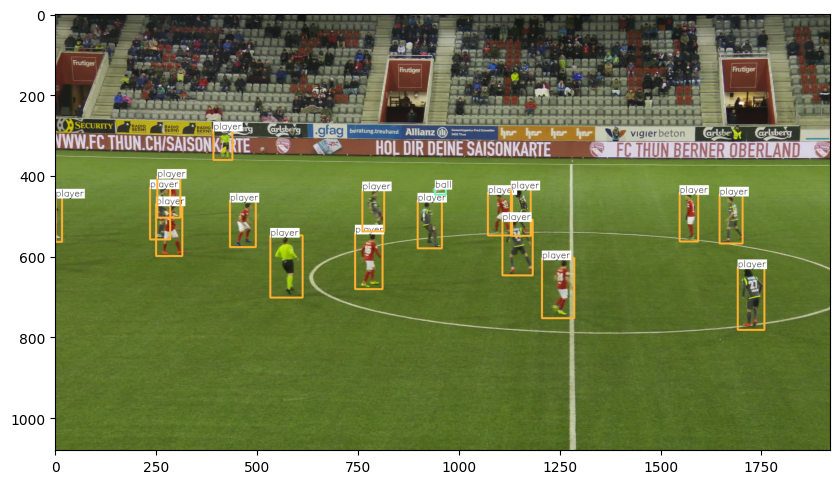

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))
i = np.random.choice(len(images))
img = images[i]
frame = cv2.imread(img)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
with open(gt_labels[i], 'r') as f:
    lines = f.readlines()
    for line in lines:
        cls, x_c_n, y_c_n, w_n, h_n = line.split()
        l, t, r, b = convert_yolo_coordinates_to_voc(x_c_n, y_c_n, w_n, h_n, 1920, 1080)
        frame = drawGT(frame, cls, l, t, r, b)
ax.imshow(frame)
            

#### Yolov8 Pretraining Results

In [8]:
### Load Yolov8
import torch
from ultralytics import YOLO

Yolov8Detector = YOLO('runs/YOLOv8/yolov8l_trackletframes-2.5k_fixed_res_1080/weights/best.pt')
Yolov8Detector.val(imgsz=1080, device=0)

WARNING ⚠️ imgsz=[1080] must be multiple of max stride 32, updating to [1088]
Ultralytics YOLOv8.0.92 🚀 Python-3.7.12 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 14910MiB)
YOLOv8l summary (fused): 268 layers, 43608150 parameters, 0 gradients, 164.8 GFLOPs
val: Scanning /home/sn3007/FootballPassPrediction/downloads/trackletframes-2.5k/labels/val.cache... 500 images, 0 backgr
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:44<
                   all        500       8595      0.834      0.738      0.743      0.447
                Player        500       8108      0.953      0.969      0.983      0.682
              Football        500        487      0.714      0.507      0.503      0.212
Speed: 0.7ms preprocess, 57.8ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/val5


ultralytics.yolo.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.yolo.utils.metrics.Metric object
confusion_matrix: <ultralytics.yolo.utils.metrics.ConfusionMatrix object at 0x7f52e4a30e10>
fitness: 0.4764771587106764
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.68207,     0.21165])
names: {0: 'Player', 1: 'Football'}
plot: True
results_dict: {'metrics/precision(B)': 0.8336997267578633, 'metrics/recall(B)': 0.7381765569331479, 'metrics/mAP50(B)': 0.7430454262393218, 'metrics/mAP50-95(B)': 0.44685846231860465, 'fitness': 0.4764771587106764}
save_dir: PosixPath('runs/detect/val5')
speed: {'preprocess': 0.710723876953125, 'inference': 57.81976556777954, 'loss': 0.000980377197265625, 'postprocess': 1.5611014366149902}

In [9]:
img = images[i]
results = Yolov8Detector.predict(source=img, device=0)


image 1/1 /home/sn3007/FootballPassPrediction/downloads/trackletframes-2.5k/images/val/SNMOT-110_000640.jpg: 640x1088 17 Players, 1 Football, 62.4ms
Speed: 4.9ms preprocess, 62.4ms inference, 1.8ms postprocess per image at shape (1, 3, 1088, 1088)


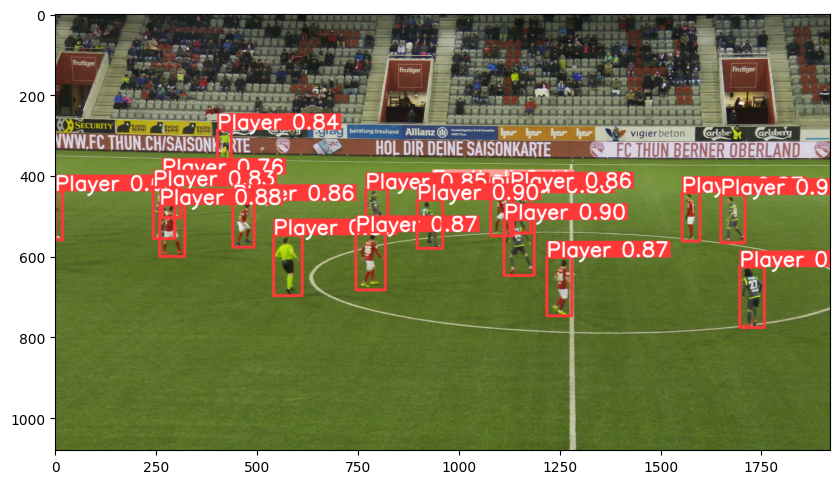

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))
res_plotted = results[0].plot()
ax.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
plt.show()

### SoccerPass (Our Dataset) Training Results

As we can see above, the Yolov8 model achieves ~$0.983$ player $mAP@0.5$, ~$0.503$ ball $mAP@0.5$ and ~$0.743$ overall $mAP@0.5$ on the tracking frames. The low performance on the ball class can be attributed to the fact that many of the frames do not have a clear view of the ball, with the ball even being missing in some of them. Unlike the tracking frames, our dataset has a selection of passing frames in which the ball is (almost always) clearly visible.<br>

Next, we take the detection model and trained it on our custom dataset with 1.2k passing frames (1k train + 200 val). For comparison, we also trained a Yolov8 model without pretraining on the tracking frames. Here are the results:

In [11]:
# With pretraining
Yolov8DetectorPT = YOLO('runs/YOLOv8/yolov8l_soccerpass_fixed_res_1080/weights/best.pt')
Yolov8DetectorPT.val(imgsz=1080, device=0)

WARNING ⚠️ imgsz=[1080] must be multiple of max stride 32, updating to [1088]
Ultralytics YOLOv8.0.92 🚀 Python-3.7.12 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 14910MiB)
YOLOv8l summary (fused): 268 layers, 43608150 parameters, 0 gradients, 164.8 GFLOPs
val: Scanning /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-YOLO/labels/val.cache... 207 images, 0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:24<
                   all        207       3311      0.962      0.962      0.975      0.723
                Player        207       3104      0.983      0.993      0.994       0.92
              Football        207        207      0.941      0.932      0.955      0.526
Speed: 1.2ms preprocess, 58.8ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val6


ultralytics.yolo.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.yolo.utils.metrics.Metric object
confusion_matrix: <ultralytics.yolo.utils.metrics.ConfusionMatrix object at 0x7f52a4d0d190>
fitness: 0.7483187670580803
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.91987,     0.52646])
names: {0: 'Player', 1: 'Football'}
plot: True
results_dict: {'metrics/precision(B)': 0.9619697400898732, 'metrics/recall(B)': 0.9624786779720106, 'metrics/mAP50(B)': 0.9747359711792032, 'metrics/mAP50-95(B)': 0.7231612999335111, 'fitness': 0.7483187670580803}
save_dir: PosixPath('runs/detect/val6')
speed: {'preprocess': 1.1846397234045942, 'inference': 58.815722304265854, 'loss': 0.000737139568236715, 'postprocess': 1.4181689939637114}

In [12]:
# Without pretraining
Yolov8Detector_NoPT = YOLO('runs/YOLOv8/yolov8l_soccerpass_fixed_res_1080_nopretrain/weights/best.pt')
Yolov8Detector_NoPT.val(imgsz=1080, device=0)

WARNING ⚠️ imgsz=[1080] must be multiple of max stride 32, updating to [1088]
Ultralytics YOLOv8.0.92 🚀 Python-3.7.12 torch-1.12.0+cu113 CUDA:0 (Tesla T4, 14910MiB)
YOLOv8l summary (fused): 268 layers, 43608150 parameters, 0 gradients, 164.8 GFLOPs
val: Scanning /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-YOLO/labels/val.cache... 207 images, 0
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:25<
                   all        207       3311      0.982      0.974      0.985      0.742
                Player        207       3104      0.984      0.992      0.994      0.921
              Football        207        207       0.98      0.956      0.975      0.562
Speed: 1.2ms preprocess, 59.1ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val7


ultralytics.yolo.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.yolo.utils.metrics.Metric object
confusion_matrix: <ultralytics.yolo.utils.metrics.ConfusionMatrix object at 0x7f51ec6f0050>
fitness: 0.7658632323899678
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.92096,     0.56212])
names: {0: 'Player', 1: 'Football'}
plot: True
results_dict: {'metrics/precision(B)': 0.9822024112591645, 'metrics/recall(B)': 0.9740604458448432, 'metrics/mAP50(B)': 0.9847739126167916, 'metrics/mAP50-95(B)': 0.7415398234758762, 'fitness': 0.7658632323899678}
save_dir: PosixPath('runs/detect/val7')
speed: {'preprocess': 1.2004145101648598, 'inference': 59.127789188698294, 'loss': 0.0010780666185461955, 'postprocess': 1.4552252304150861}

**With Pretraining**: ~$0.994$ player $mAP@0.5$, ~$0.955$ ball $mAP@0.5$ and ~$0.975$ overall $mAP@0.5$ <br>
**Without Pretraining**: ~$0.994$ player $mAP@0.5$, ~$0.975$ ball $mAP@0.5$ and ~$0.985$ overall $mAP@0.5$, with significantly higher $mAP@0.05:0.95$ for all categories (see above) <br>

The results indicate that pretraining on the tracking frames did not provide improved performance, and the model performed better overall on our dataset without pretraining. We then select this as our best model for the E2E pipeline.

In [13]:
# Visualization on an example from our dataset

#Get random image
soccerpass_val_imgs = os.listdir('downloads/SoccerPass/SoccerPass-YOLO/images/val')
i = np.random.choice(len(soccerpass_val_imgs))

img_src = os.path.join('downloads/SoccerPass/SoccerPass-YOLO/images/val', soccerpass_val_imgs[i])

#Run inference
results = Yolov8Detector_NoPT.predict(source=img_src, device=0)


image 1/1 /home/sn3007/FootballPassPrediction/downloads/SoccerPass/SoccerPass-YOLO/images/val/image_prtl_1128.png: 640x1088 17 Players, 1 Football, 68.2ms
Speed: 5.3ms preprocess, 68.2ms inference, 1.5ms postprocess per image at shape (1, 3, 1088, 1088)


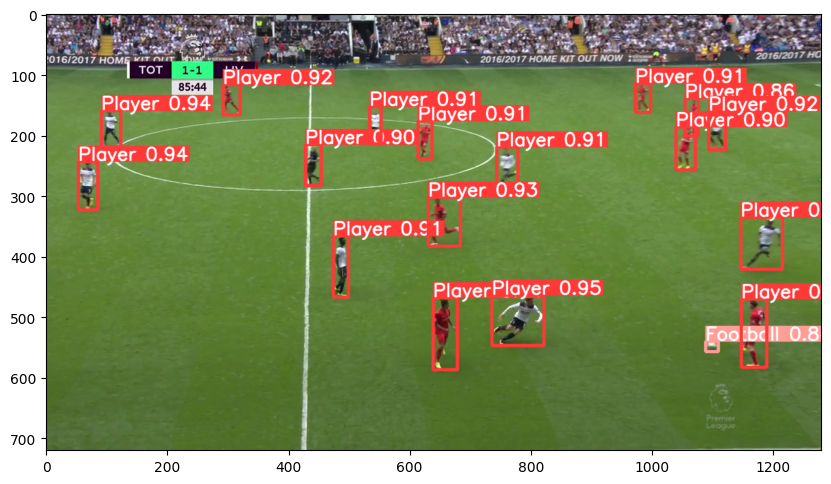

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
res_plotted = results[0].plot()
ax.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
plt.show()